In [68]:
words = open('names.txt', 'r').read().splitlines()

In [69]:
# Instead of a dictionary, we can store the bigrams in a 2D array
import torch

In [70]:
N = torch.zeros((27,27), dtype=torch.int32) # datatype --> float32 single precision floating point BY DEFAULT

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0


In [71]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [72]:
itos = {s:i for i, s in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Normalising rows and creating probabilty distribution

In [73]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

# Sampling using torch.multinomial

In [74]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p/p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [75]:
"""
Above p is [0.6064, 0.3033, 0.0903] , here 1st element is 60%, second is 30% and the third is 10%

When we sample using torch.multinomial, lets say 20 samples, then 60% of the samples will be 0 (since 0th index of p is 0.6), 30% of samples will be 1 and the rest 10% will be 2


So, the sampling picks the index number from the probablity distribution we provide to it. Also replacement = False by default, so be careful
"""

torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

# Sampling from the actual data

In [76]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    ix = 0
    out = []
    while True:
        """
        here we are starting from the '.' character then we are sampling the next probable character from the distribution
        then we take update the index ix to that character and continue sampling the next probable character
        until we get '.' character which would denote end of the word/string
        """
        p = N[ix].float()
        p/=p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        # print(itos[ix])
        out.append(itos[ix])

        if ix == 0:
            break

    # print(''.join(out))

# Optimising using Broadcasting

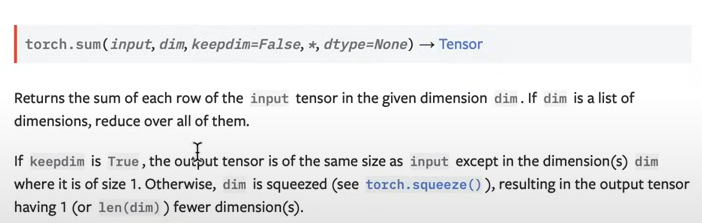

Broadcasting Rules
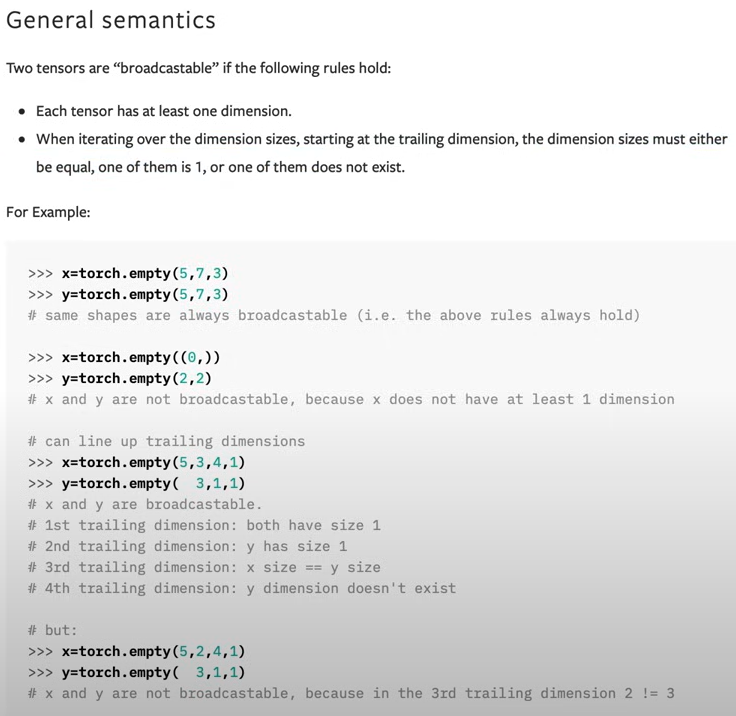

In [77]:
fake_counts = 5

"""Fake counts for model smoothening"""

P = (N + fake_counts).float() 
P /= P.sum(1, keepdim=True) # We are summing up across the columns since we want the sum of all rows

In [78]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    ix = 0
    out = []
    while True:
        """
        here we are starting from the '.' character then we are sampling the next probable character from the distribution
        then we take update the index ix to that character and continue sampling the next probable character
        until we get '.' character which would denote end of the word/string
        """
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        out.append(itos[ix])

        if ix == 0:
            break

    # print(''.join(out))

Now we have a trained BIGRAM LANGUAGE MODEL,
Lets see how much probabilty it assigns to the bigrams in the training set

In [79]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood
normalised_nll = nll/n
print(f'loss : {normalised_nll}')

.e: 0.0477 -3.0418
em: 0.0376 -3.2794
mm: 0.0255 -3.6680
ma: 0.3829 -0.9599
a.: 0.1953 -1.6331
.o: 0.0124 -4.3898
ol: 0.0773 -2.5596
li: 0.1763 -1.7354
iv: 0.0154 -4.1758
vi: 0.3383 -1.0839
ia: 0.1374 -1.9851
a.: 0.1953 -1.6331
.a: 0.1372 -1.9860
av: 0.0247 -3.7025
va: 0.2389 -1.4316
a.: 0.1953 -1.6331
loss : 2.4311392307281494
